In [9]:
# standard python imports
import numpy as np
import os
import scipy
import astropy.io.fits as pyfits
import scipy.ndimage
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

# lenstronomy utility functions
import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util

# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
from lenstronomy.LightModel.Profiles.shapelets_polar import ShapeletSetPolar

In [27]:
# define data specifics
background_rms = .2  #  background noise per pixel
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 64  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
factor = 5
subgrid_res = factor  # we set the subgrid resolution to the high resolution image that we will show, so the same numerics will be applied.
fwhm = 0.1 # full width half max of PSF
psf_type = 'GAUSSIAN'  # 'gaussian', 'pixel', 'NONE'

# define lens model
lens_model_list = ['SPEP', 'SHEAR']
kwargs_spemd = {'theta_E': 0.5, 'gamma': 2., 'center_x':0, 'center_y': 0, 'e1': 0, 'e2': 0}
kwargs_shear = {'gamma1': 0.0, 'gamma2': 0.0}
kwargs_lens = [kwargs_spemd, kwargs_shear]

# define center of the source (effectively the center of the Shapelet basis)
source_x = 0.2
source_y = 0.

# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]

k_main_deflector_light = False
if k_main_deflector_light:
    lens_x = 0.0
    lens_y = 0.0

    phi_G, q = 0.9, 0.9
    e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
    kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': lens_x, 'center_y': lens_y}
    lens_light_model_list = ['SERSIC_ELLIPSE']
    kwargs_lens_light = [kwargs_sersic_lens]
    lens_light_model_class = LightModel(light_model_list=lens_light_model_list)
else:
    lens_light_model_list = ['NONE']
    kwargs_lens_light = [{}]
    lens_light_model_class = None

lensModel = LensModel(lens_model_list)
sourceLightModel = LightModel(source_model_list)

In [28]:
shapeletSet = ShapeletSet()

# final data configuration
kwargs_data_real = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_real = ImageData(**kwargs_data_real)

psf = PSF(psf_type=psf_type, fwhm=fwhm, truncation=5)
psf_no = PSF(psf_type='NONE')

# the numerics applied on the final data output to perform the identical computation as the high resolution gird
# kwargs_numerics = {'supersampling_factor': subgrid_res, 'supersampling_convolution': True}
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

# and here we perform the computations
unlensed_source_nonoise_model = ImageModel(data_class=data_real, psf_class=psf, kwargs_numerics=kwargs_numerics, lens_model_class=None, source_model_class=sourceLightModel, lens_light_model_class=None)
unlensed_source_nonoise = unlensed_source_nonoise_model.image(None, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

unlensed_full_nonoise_model = ImageModel(data_class=data_real, psf_class=psf_no, kwargs_numerics=kwargs_numerics, source_model_class=sourceLightModel, lens_light_model_class=lens_light_model_class)
unlensed_full_nonoise = unlensed_full_nonoise_model.image(kwargs_lens=None, kwargs_source=kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)

lensed_full_nonoise_model = ImageModel(data_class=data_real, psf_class=psf_no, kwargs_numerics=kwargs_numerics, lens_model_class=lensModel, source_model_class=sourceLightModel, lens_light_model_class=lens_light_model_class)
lensed_full_nonoise = lensed_full_nonoise_model.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)

lensed_full_psf_model = ImageModel(data_class=data_real, psf_class=psf, kwargs_numerics=kwargs_numerics, lens_model_class=lensModel, source_model_class=sourceLightModel, lens_light_model_class=lens_light_model_class)
lensed_full_psf = lensed_full_psf_model.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)

poisson = image_util.add_poisson(lensed_full_psf, exp_time=exp_time)
bkg = image_util.add_background(lensed_full_psf, sigma_bkd=background_rms)
lensed_full_noised = lensed_full_psf + poisson + bkg

/tmp/ipykernel_4105525/3556428174.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color='k', alpha=1.)
/tmp/ipykernel_4105525/3556428174.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_under('k')


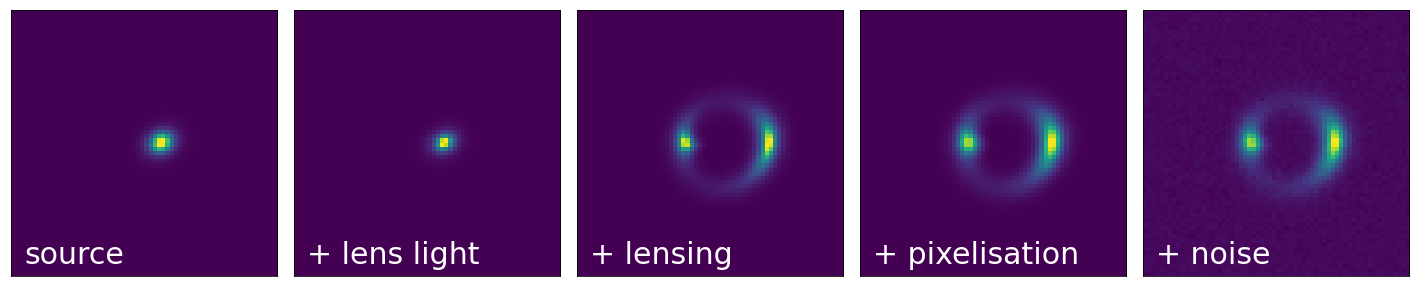

In [29]:
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = 0
v_max = 2

label_to_image = {
    "source": unlensed_source_nonoise,
    "+ lens light": unlensed_full_nonoise,
    "+ lensing": lensed_full_nonoise,
    "+ pixelisation": lensed_full_psf,
    "+ noise": lensed_full_noised,
}

f, axes = plt.subplots(1, len(label_to_image), figsize=(20, 4), sharex=False, sharey=False)
for i, label in enumerate(label_to_image):
    ax = axes[i]
    im = ax.matshow((label_to_image[label]), origin='lower', extent=[0, 1, 0, 1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.autoscale(False)

    ax = axes[i]
    x_pos, y_pos = 0.05, 0.05
    fontsize_description = 30
    ax.text(x_pos, y_pos, label, color="w", fontsize=fontsize_description)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

In [30]:
from lenstronomy.LightModel.Profiles.shapelets_polar import ShapeletSetPolar

data_real.update_data(image_real_lensed)
shapelet_type = 'polar' # 'cartesian', 'polar', 'exponential'

if shapelet_type == 'exponential':
    sourceLightModel_reconstruct = LightModel(['SHAPELETS_POLAR_EXP'])
    shapeletSet_reconstruct = ShapeletSetPolar(exponential=True)
    n_max_reconstruct = 7
    beta_reconstruct = 0.02
elif shapelet_type == 'polar':
    
    shapeletSet_reconstruct = ShapeletSetPolar(exponential=False)
    sourceLightModel_reconstruct = LightModel(['SHAPELETS_POLAR'])
    n_max_reconstruct = 20
    beta_reconstruct = 0.15
else:
    sourceLightModel_reconstruct = LightModel(['SHAPELETS'])
    shapeletSet_reconstruct = shapeletSet
    n_max_reconstruct = 20
    beta_reconstruct = 0.15

from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
imageModel = ImageLinearFit(data_class=data_real, psf_class=psf, kwargs_numerics=kwargs_numerics, lens_model_class=lensModel, source_model_class=sourceLightModel_reconstruct, lens_light_model_class=lens_light_model_class)

kwargs_lens = [kwargs_spemd, kwargs_shear]  # we use the same lens model to reconstruct the image
kwargs_source = [{'n_max': n_max_reconstruct, 'center_x': source_x, 'center_y': source_y, 'beta': beta_reconstruct}]

# this is the linear inversion
wls_model, _, cov_param, param = imageModel.image_linear_solve(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None, inv_bool=False)
lensed_reconstructed = wls_model

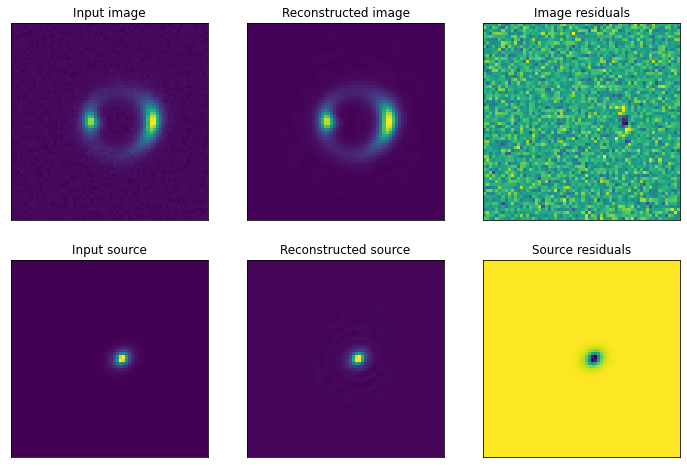

Max image value: 29.957764457351765
Max residual: 0.011414341575042524


In [31]:
# given the solution of the linear inversion, we can also plot the coefficients in the source plane

x_coords, y_coords = data_real.pixel_coordinates
source_reconstructed = shapeletSet_reconstruct.function(util.image2array(x_coords), util.image2array(y_coords), param, n_max_reconstruct, beta_reconstruct, center_x=source_x, center_y=source_y)
source_reconstructed_2d = util.array2image(source_reconstructed) * (deltaPix/factor)**2  # map 1d data vector in 2d image
reduced_residuals = imageModel.reduced_residuals(wls_model)
label_to_image = {
    "Input image": image_real_lensed,
    "Reconstructed image": wls_model,
    "Image residuals": reduced_residuals,
    "Input source": image_nolens_large,
    "Reconstructed source": source_reconstructed_2d,
    "Source residuals": source_reconstructed_2d - image_nolens_large,
}

f, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=False)
for i, label in enumerate(label_to_image):
    ax = axes[i // 3, i - 3 * (i // 3)]
    ax.matshow(label_to_image[label], origin='lower')
    ax.set_title(label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.autoscale(False)
plt.show()

print(f"Max image value: {np.max(image_nolens_large)}")
print(f"Max residual: {np.max(source_reconstructed_2d - image_nolens_large)}")